In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_moons
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline

from imblearn.under_sampling import OneSidedSelection

from imblearn.metrics import (geometric_mean_score, sensitivity_score, 
                              specificity_score)

from sklearn.metrics import (balanced_accuracy_score, precision_score, 
                             recall_score, f1_score)

from google.colab import files

In [2]:
import scipy as sc
import matplotlib.style

params = {'legend.fontsize': 18,
          'axes.labelsize': 18,
          'axes.titlesize': 16,
          'xtick.labelsize' :12,
          'ytick.labelsize': 12,
          'grid.color': 'k',
          'grid.linestyle': ':',
          'grid.linewidth': 0.5,
          'mathtext.fontset' : 'stix',
          'mathtext.rm'      : 'serif',
          'font.family'      : 'serif',
          'font.serif'       : "Times New Roman", # or "Times"          
         }
matplotlib.rcParams.update(params)

In [3]:
datasets = [
    make_moons(n_samples=(400, 8), noise=0.1, random_state=0),
]

classifiers = MLPClassifier(hidden_layer_sizes=(100), activation='relu', solver='adam', alpha=0.0001, batch_size='auto',  
              max_iter=1000, verbose=False, early_stopping=False, random_state=1)

In [4]:
sampling_names = [
         r'$\mathrm{One-Sided}$ $\mathrm{Selection}$'
         ]

#undersampling technique
onesideundersampler = OneSidedSelection(random_state=0)

sampling_functions = [
                      onesideundersampler
                           ]

In [5]:
def plot_decision_function(X, y, classifiers, coordinate_x, coordinate_y, ax, title):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#C82506', '#0365C0'])
    
    if hasattr(classifiers, "decision_function"):
            Z = classifiers.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
            Z = classifiers.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)

    [x.set_linewidth(1.1) for x in ax.spines.values()]
    ax.contourf(xx, yy, Z, 9, cmap=cm, alpha=0.8)
    ax.contour(xx, yy, Z, 9, antialiased=True, linewidths=0.5, colors='k')
    ax.contour(xx, yy, Z, 1, antialiased=True, linewidths=1.3, colors='k')
    ax.axhline(y=coordinate_y, ls='--', lw=0.8, color='k', alpha=0.8)
    ax.axvline(x=coordinate_x, ls='--', lw=0.8, color='k', alpha=0.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k", s=50, alpha=1.0) 
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_title(title)
    plt.savefig('onesided.png', bbox_inches='tight', dpi=1200)
    files.download('onesided.png') 
    plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

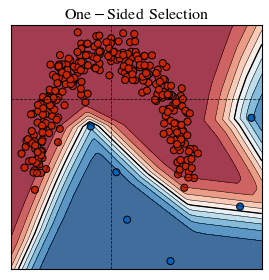

F1 Score: 0.667
Geometric Mean: 0.707
Balanced Accuracy Score: 0.750
Sensitivity Score: 0.500
Specificity Score: 1.000
Precision Score: 1.000
Recall Score: 0.500
{'onesidedselection__n_neighbors': 2, 'onesidedselection__n_seeds_S': 2, 'onesidedselection__sampling_strategy': 'majority'}


<Figure size 432x288 with 0 Axes>

In [6]:
i = 1

for ds_cnt, ds in enumerate(datasets):
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    i += 1 

    for sampling_name, sampling_function in zip(sampling_names, sampling_functions):
        fig, ax = plt.subplots(figsize=(4.5,4.5))  
        model = make_pipeline(sampling_function, classifiers)
 
        param = [
                 {'onesidedselection' + '__sampling_strategy': ['majority', 'not majority', 'all'], 'onesidedselection' + '__n_neighbors': [1, 2, 3, None], 'onesidedselection' + '__n_seeds_S': [1, 2, 3] }     
                 ]

        gridsearch = GridSearchCV(model, param, scoring='f1', cv=5, verbose=1738, n_jobs=-1, error_score="raise") 
        best_model = gridsearch.fit(X_train, y_train)


        plot_decision_function(X_train, y_train, best_model, 0, 0, ax, sampling_name)

        y_pred = best_model.predict(X_test)
        print(f"F1 Score: {f1_score(y_test, y_pred, average='binary'):.3f}")
        print(f"Geometric Mean: {geometric_mean_score(y_test, y_pred, average='binary'):.3f}")
        print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_test, y_pred):.3f}")
        print(f"Sensitivity Score: {sensitivity_score(y_test, y_pred, average='binary'):.3f}")
        print(f"Specificity Score: {specificity_score(y_test, y_pred, average='binary'):.3f}")
        print(f"Precision Score: {precision_score(y_test, y_pred, average='binary'):.3f}")
        print(f"Recall Score: {recall_score(y_test, y_pred, average='binary'):.3f}")
        print(gridsearch.best_params_) 

        i += 1    

plt.tight_layout()
plt.show()